In [1]:
#install.packages(c("matrixStats", "Hmisc", "splines", "foreach", "doParallel", "fastcluster", "dynamicTreeCut", "survival")) 
#BiocManager::install((c("GO.db", "preprocessCore", "impute")))
#BiocManager::install('WGCNA')

In [2]:
library(robustHD)
# from https://gist.github.com/stevenworthington/3178163
ipak <- function(pkg){
    new.pkg <- pkg[!(pkg %in% installed.packages()[, "Package"])]
    if (length(new.pkg))
        install.packages(new.pkg, dependencies = TRUE, repos = "http://cran.r-project.org")
    sapply(pkg, require, character.only = TRUE)
}

# usage
packages <- c("ggplot2",  "gplots", "lattice", "plyr", "reshape2",
              "RColorBrewer", "grid", "gridExtra", "igraph", "igraphdata")
suppressMessages(ipak(packages))

Loading required package: ggplot2
Loading required package: perry
Loading required package: parallel
Loading required package: robustbase


ggplot2       gplots      lattice         plyr     reshape2 RColorBrewer 
        TRUE         TRUE         TRUE         TRUE         TRUE         TRUE 
        grid    gridExtra       igraph   igraphdata 
        TRUE         TRUE         TRUE         TRUE

In [3]:
library(WGCNA);
options(stringsAsFactors = FALSE)
(.packages())
library(robustHD)

Loading required package: dynamicTreeCut
Loading required package: fastcluster

Attaching package: ‘fastcluster’

The following object is masked from ‘package:stats’:

    hclust



Attaching package: ‘WGCNA’

The following object is masked from ‘package:stats’:

    cor



[1] "WGCNA"          "fastcluster"    "dynamicTreeCut" "igraphdata"    
 [5] "igraph"         "gridExtra"      "grid"           "RColorBrewer"  
 [9] "reshape2"       "plyr"           "lattice"        "gplots"        
[13] "robustHD"       "perry"          "robustbase"     "parallel"      
[17] "ggplot2"        "stats"          "graphics"       "grDevices"     
[21] "utils"          "datasets"       "methods"        "base"

In [4]:
#load proteomics data without imputation
LC_data = read.csv("proteomics_not_imputed.csv");
# tranpose data 
LC_data=t(LC_data)
#Take a quick look at what is in the data set:
dim(LC_data)
#head(LC_data)
#save column names
LC_data_names<-LC_data[1,]
#convert to df
LC_data=as.data.frame(LC_data)
#subset just the sample rows in the df
LC_data=LC_data[3:50,]
dim(LC_data)

[1]   50 3969

[1]   48 3969

In [5]:
#name columns in df
colnames(LC_data)<-LC_data_names
#convert df to numeric and replace 0 with NA (missing)
num_df<-sapply(LC_data, function(x) as.numeric(as.character(x)))
num_df[num_df==0.00]<-NA

In [6]:
#save the processed df
write.csv(num_df,'proteomics_cleaned.csv')

In [7]:
#filter columns (proteins) by missingness using code provided by WGCNA authors (50% default threshold)
gsg = goodSamplesGenes(num_df, verbose = 1);
gsg$allOK
if (!gsg$allOK)
{
  # Optionally, print the gene and sample names that were removed:
  if (sum(!gsg$goodGenes)>0) 
     printFlush(paste("Removing genes:", paste(names(num_df)[!gsg$goodGenes], collapse = ", ")));
  if (sum(!gsg$goodSamples)>0) 
     printFlush(paste("Removing samples:", paste(rownames(num_df)[!gsg$goodSamples], collapse = ", ")));
  # Remove the offending genes and samples from the data:
  num_df = num_df[gsg$goodSamples, gsg$goodGenes]
}

 Flagging genes and samples with too many missing values...
  ..step 1
  ..step 2


[1] FALSE

Removing genes: 


In [8]:
#check df after filtering proteins with high missingness
dim(num_df)

[1]   48 3441

In [9]:
#exclude proteins not mapped to mouse (human proteins)
non_human_genes<-c(
'sp|ALBU_BOVIN|',
'sp|K1C10_HUMAN|',
'sp|K1C9_HUMAN|',
'sp|K22E_HUMAN|',
'sp|K2C1_HUMAN|',
'sp|TRYP_PIG|')
dim(num_df)
num_df = num_df[,!(colnames(num_df) %in% non_human_genes)]
dim(num_df)

[1]   48 3441

[1]   48 3435

pickSoftThreshold: will use block size 3435.
 pickSoftThreshold: calculating connectivity for given powers...


Warning message in corOptions$nThreads = 1:
“Coercing LHS to a list”

   ..working on genes 1 through 3435 of 3435


Warning message:
“executing %dopar% sequentially: no parallel backend registered”

   Power SFT.R.sq  slope truncated.R.sq mean.k. median.k. max.k.
1      1    0.421  0.498          0.582  907.00   960.000 1570.0
2      2    0.218 -0.333          0.692  401.00   398.000  925.0
3      3    0.543 -0.778          0.843  206.00   187.000  596.0
4      4    0.659 -1.020          0.895  116.00    94.900  405.0
5      5    0.720 -1.180          0.916   69.40    51.500  286.0
6      6    0.766 -1.270          0.938   43.90    28.800  208.0
7      7    0.791 -1.350          0.948   28.90    17.200  155.0
8      8    0.802 -1.390          0.948   19.60    10.400  117.0
9      9    0.818 -1.440          0.953   13.70     6.580   90.6
10    10    0.829 -1.470          0.956    9.81     4.190   71.0
11    11    0.844 -1.480          0.963    7.16     2.770   56.3
12    12    0.856 -1.470          0.970    5.32     1.840   45.1
13    13    0.867 -1.460          0.976    4.01     1.240   36.5
14    14    0.876 -1.460          0.981    3.07     0.836   29.8
15    15    0.883 -1.470 

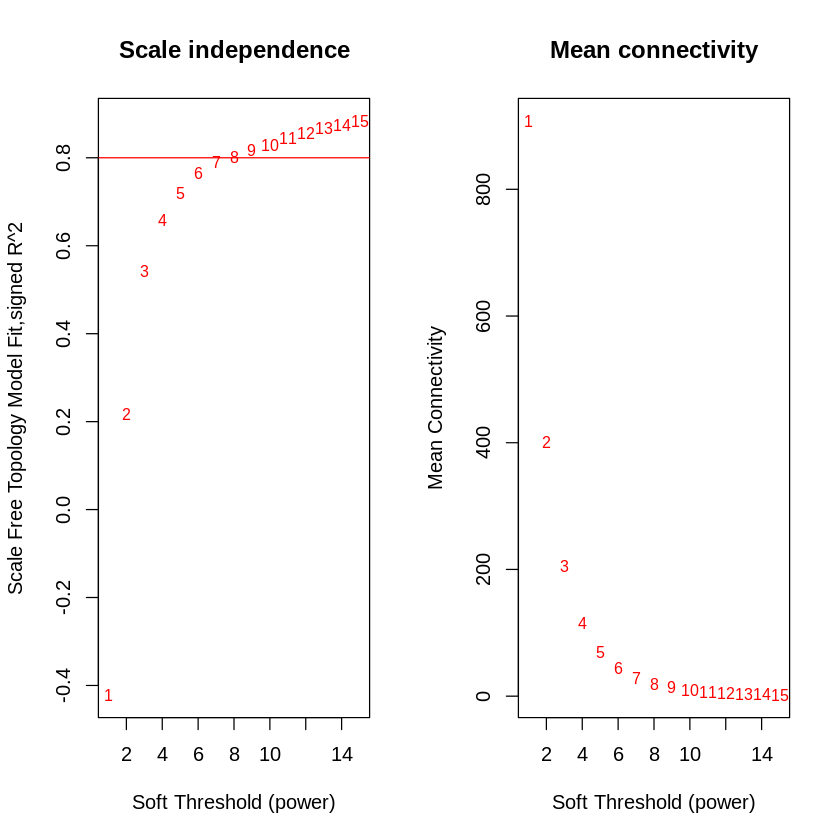

In [10]:
# now that the data has been processed and cleaned accordingly, the next step is to choose the right beta value to approximate 
# a scale free topology
# Choose a set of soft-thresholding powers
powers = c(c(1:10), seq(from = 11, to=15, by=1))
# Call the network topology analysis function
sft = pickSoftThreshold(num_df, powerVector = powers, verbose = 5,corOptions=c(use='p',method='spearman'), networkType='signed hybrid')
# Plot the results:
#sizeGrWindow(9, 5)
par(mfrow = c(1,2));
cex1 = 0.8;
# Scale-free topology fit index as a function of the soft-thresholding power
plot(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
     xlab="Soft Threshold (power)",ylab="Scale Free Topology Model Fit,signed R^2",type="n",
    main = paste("Scale independence"));
text(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
    labels=powers,cex=cex1,col="red");
# this line corresponds to using an R^2 cut-off of h
abline(h=0.80,col="red")
# Mean connectivity as a function of the soft-thresholding power
plot(sft$fitIndices[,1], sft$fitIndices[,5],
    xlab="Soft Threshold (power)",ylab="Mean Connectivity", type="n",
    main = paste("Mean connectivity"))
text(sft$fitIndices[,1], sft$fitIndices[,5], labels=powers, cex=cex1,col="red")

In [11]:
#generate the adjacency matrix using the chosen soft-thresholding power
softPower = 7;
adjacency = adjacency(num_df, power = softPower,corOptions=list(use='p',method='spearman'),type = "signed hybrid" );

In [12]:
# Turn adjacency into topological overlap
TOM = TOMsimilarity(adjacency,TOMType = "signed");
dissTOM = 1-TOM

..connectivity..
..matrix multiplication (system BLAS)..
..normalization..
..done.


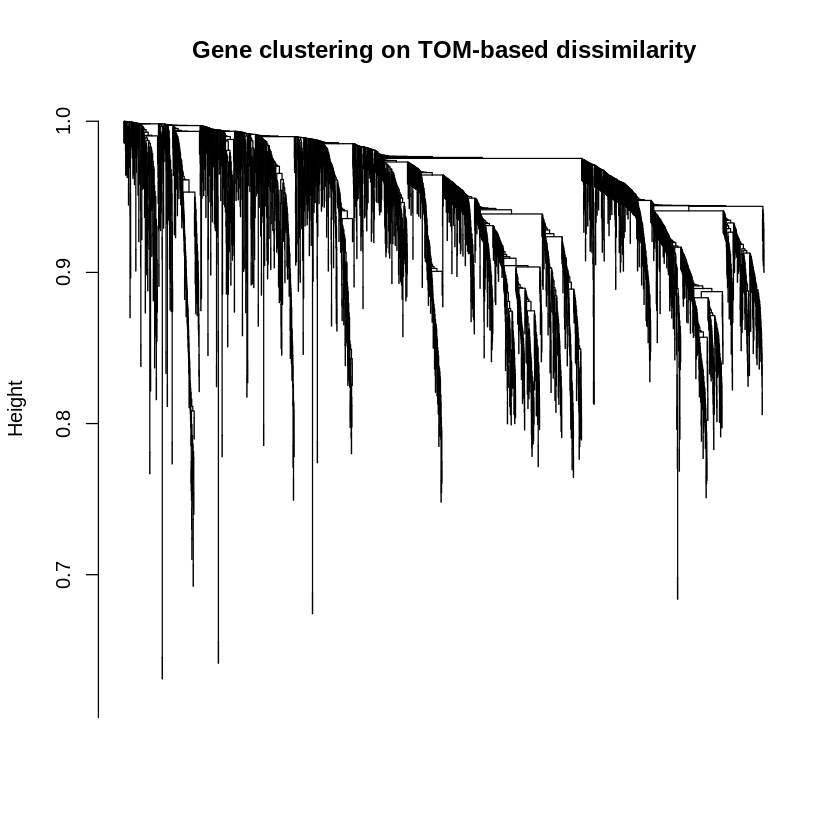

In [13]:
# Call the hierarchical clustering function
geneTree = hclust(as.dist(dissTOM), method = "average");
# Plot the resulting clustering tree (dendrogram)
#sizeGrWindow(12,9)
plot(geneTree, xlab="", sub="", main = "Gene clustering on TOM-based dissimilarity",
    labels = FALSE, hang = 0.04);

In [14]:
#We like large modules, so we set the minimum module size relatively high:
minModuleSize = 30;
# Module identification using dynamic tree cut:
dynamicMods = cutreeDynamic(dendro = geneTree, distM = dissTOM,
              deepSplit = 3, pamRespectsDendro = FALSE,
              minClusterSize = minModuleSize);
table(dynamicMods)

 ..cutHeight not given, setting it to 0.998  ===>  99% of the (truncated) height range in dendro.
 ..done.


dynamicMods
  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19 
 24 567 285 275 272 180 160 156 156 154 149 147 126 117 117 109  76  75  70  68 
 20  21  22 
 66  46  40 

dynamicColors
       black         blue        brown         cyan    darkgreen      darkred 
         156          285          275          117           40           46 
       green  greenyellow         grey       grey60    lightcyan   lightgreen 
         180          147           24           75           76           70 
 lightyellow      magenta midnightblue         pink       purple          red 
          68          154          109          156          149          160 
   royalblue       salmon          tan    turquoise       yellow 
          66          117          126          567          272 

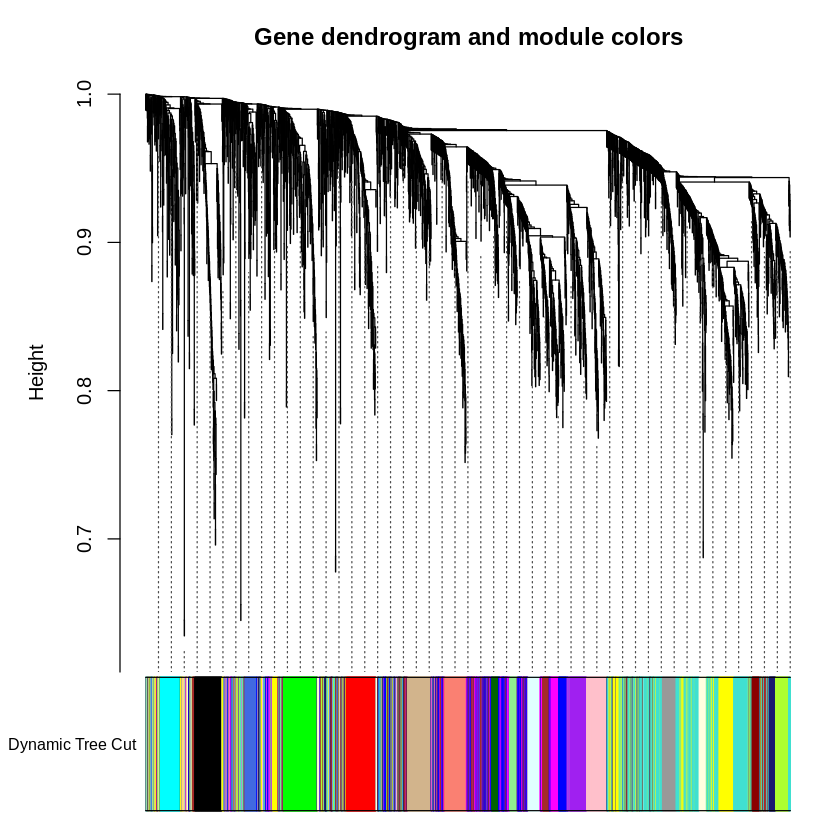

In [15]:
# Convert numeric lables into colors
dynamicColors = labels2colors(dynamicMods)
table(dynamicColors)
# Plot the dendrogram and colors underneath
#sizeGrWindow(8,6)
plotDendroAndColors(geneTree, dynamicColors, "Dynamic Tree Cut",
                  dendroLabels = FALSE, hang = 0.03,
                  addGuide = TRUE, guideHang = 0.05,
                  main = "Gene dendrogram and module colors")

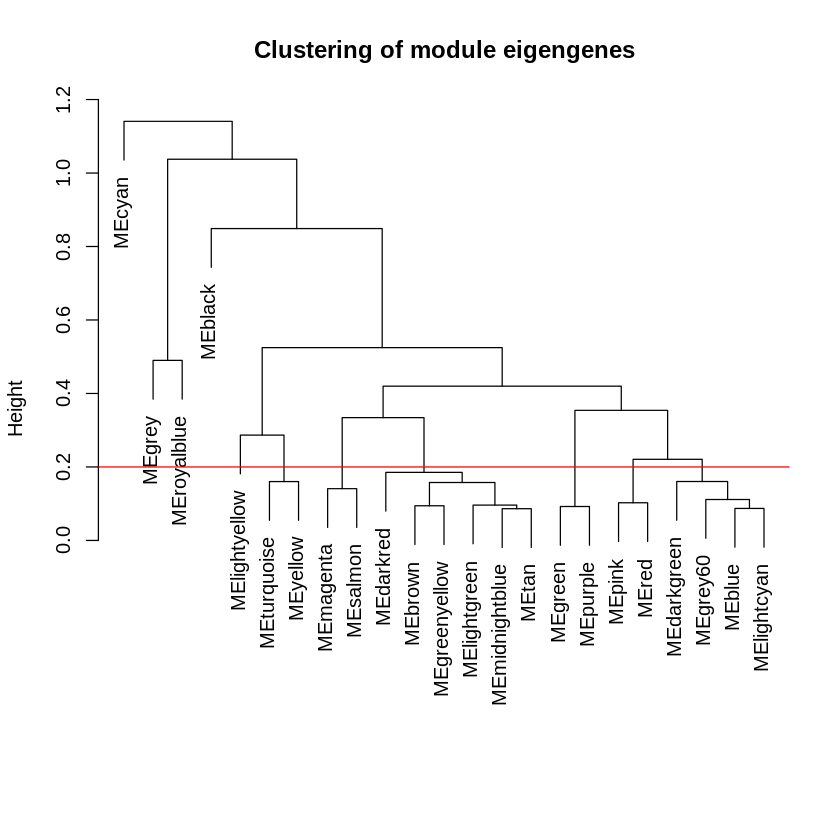

In [16]:
# Calculate eigengenes
MEList = moduleEigengenes(num_df, colors = dynamicColors,nPC = 2)
MEs = MEList$eigengenes
# Calculate dissimilarity of module eigengenes
MEDiss = 1-cor(MEs);
# Cluster module eigengenes
METree = hclust(as.dist(MEDiss), method = "average");
# Plot the result
#sizeGrWindow(7, 6)
plot(METree, main = "Clustering of module eigengenes",
xlab = "", sub = "")
MEDissThres = .2
abline(h=MEDissThres, col = "red")

 mergeCloseModules: Merging modules whose distance is less than 0.2
   multiSetMEs: Calculating module MEs.
     Working on set 1 ...
     moduleEigengenes: Calculating 23 module eigengenes in given set.
   multiSetMEs: Calculating module MEs.
     Working on set 1 ...
     moduleEigengenes: Calculating 11 module eigengenes in given set.
   multiSetMEs: Calculating module MEs.
     Working on set 1 ...
     moduleEigengenes: Calculating 10 module eigengenes in given set.
   Calculating new MEs...
   multiSetMEs: Calculating module MEs.
     Working on set 1 ...
     moduleEigengenes: Calculating 10 module eigengenes in given set.


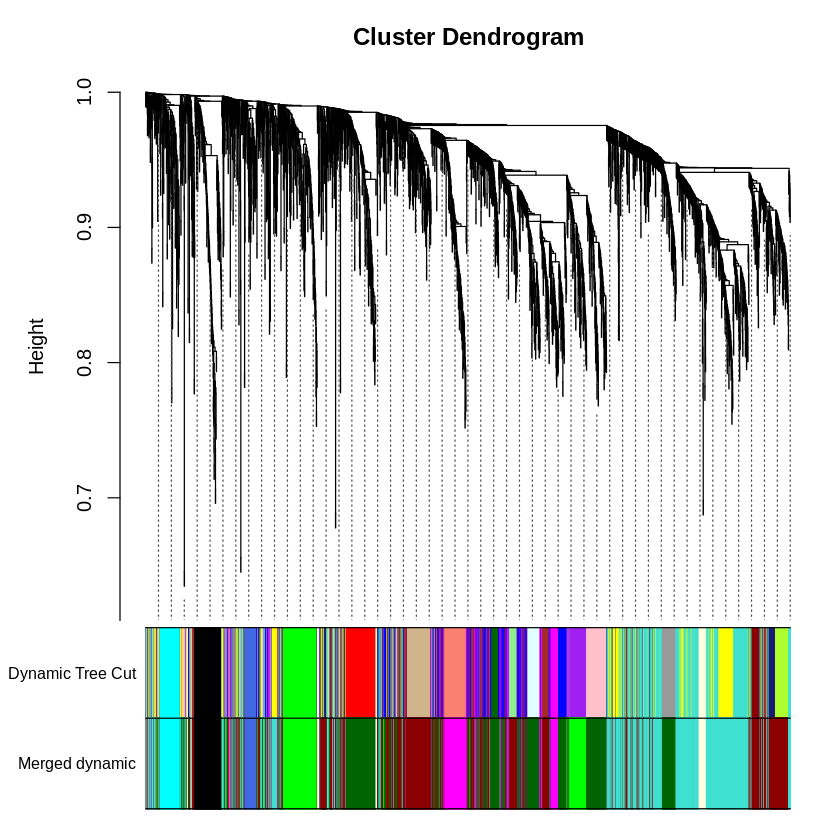

In [17]:
# Call an automatic merging function
merge = mergeCloseModules(num_df, dynamicColors, cutHeight = MEDissThres, verbose = 3)
# The merged module colors
mergedColors = merge$colors;
# Eigengenes of the new merged modules:
mergedMEs = merge$newMEs;
#pdf(file = "Plots/geneDendro-3.pdf", wi = 9, he = 6)
plotDendroAndColors(geneTree, cbind(dynamicColors, mergedColors),
c("Dynamic Tree Cut", "Merged dynamic"),
dendroLabels = FALSE, hang = 0.03,
addGuide = TRUE, guideHang = 0.05)

In [18]:
# Rename to moduleColors
moduleColors = mergedColors
# Construct numerical labels corresponding to the colors
colorOrder = c("grey", standardColors(50));
moduleLabels = match(moduleColors, colorOrder)-1;
MEs = mergedMEs;
# Save module colors and labels for use in subsequent parts
#save(MEs, moduleLabels, moduleColors, geneTree, file = "FemaleLiver-02-networkConstruction-stepByStep.RData")

In [19]:
#Save module eigenvalues
rownames(MEs)<-rownames(LC_data)
write.csv(MEs,'MEs.csv')

In [20]:
# Define numbers of genes and samples
nGenes = ncol(num_df);
nSamples = nrow(num_df);
geneModuleMembership = as.data.frame(cor(num_df, MEs, use = "p"));
MMPvalue = as.data.frame(corPvalueStudent(as.matrix(geneModuleMembership), nSamples));

In [21]:
modNames = substring(names(MEs), 3)
names(geneModuleMembership) = paste("MM", modNames, sep="");
names(MMPvalue) = paste("p.MM", modNames, sep="");
write.csv(geneModuleMembership[order(geneModuleMembership$MMdarkgreen),],'module_membership.csv')

In [22]:
# Recalculate topological overlap
TOM = TOMsimilarity(adjacency,TOMType = "signed");
# Read in the annotation file
annot = read.csv(file = "annotated_genes.csv");
# Select module
module = "darkgreen";
# Select module probes
probes = colnames(num_df)
inModule = (moduleColors==module);
modProbes = probes[inModule];
# Select the corresponding Topological Overlap
modTOM = TOM[inModule, inModule];
dimnames(modTOM) = list(modProbes, modProbes)
# Export the network into an edge list file VisANT can read
vis = exportNetworkToVisANT(modTOM,
  file = paste("VisANTInput-", module, ".txt", sep=""),
  weighted = TRUE,
  threshold = 0,
  probeToGene = data.frame(annot$gene, annot$final_gene) )

..connectivity..
..matrix multiplication (system BLAS)..
..normalization..
..done.


In [23]:
length(modProbes)

[1] 792

In [24]:
nTop = 30;
IMConn = softConnectivity(num_df[, modProbes],corOptions=list(use='p',method='spearman'),type="signed hybrid",power=7);
top = (rank(-IMConn) <= nTop)
vis = exportNetworkToVisANT(modTOM[top, top],
  file = paste("VisANTInput-", module, "-top30.txt", sep=""),
  weighted = TRUE,
  threshold = 0,
  probeToGene = data.frame(annot$gene, annot$final_gene) )

 softConnectivity: FYI: connecitivty of genes with less than 16 valid samples will be returned as NA.
 ..calculating connectivities.. 


In [25]:
connectivity<-as.data.frame(modProbes)
connectivity$connect<-IMConn
connectivity$tom_score<-rowSums(modTOM)
write.csv(connectivity,'darkgreen_connectivity.csv')

In [26]:
module = "darkgreen"
column = match(module, modNames);
moduleGenes = moduleColors==module;

In [27]:
genes<-t(num_df)
d<-as.data.frame(moduleColors)
d$gene<-rownames(genes)
head(d)

moduleColors,gene
<chr>,<chr>
darkred,sp|A0JNU3|LPP60_MOUSE
lightyellow,sp|A2A432|CUL4B_MOUSE
magenta,sp|A2A5R2|BIG2_MOUSE
darkred,sp|A2A8Z1|OSBL9_MOUSE
cyan,sp|A2A935|PRD16_MOUSE
turquoise,sp|A2ADY9|DDI2_MOUSE


In [28]:
#save assignment of each protein to specific module
write.csv(d,'module_assignments.csv')